In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu


In [67]:
df = pd.read_csv('cookie_cats.csv')

In [68]:
#preview first 5 rows
print("\nData Preview:")
print(df.head())



Data Preview:
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


In [69]:
#check missing values and data types
print("\nData Info:")
print(df.info())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


In [70]:
#check number of players in each A/B group
print("\nGroup Sizes:")
print(df.groupby('version')['userid'].count())


Group Sizes:
version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64


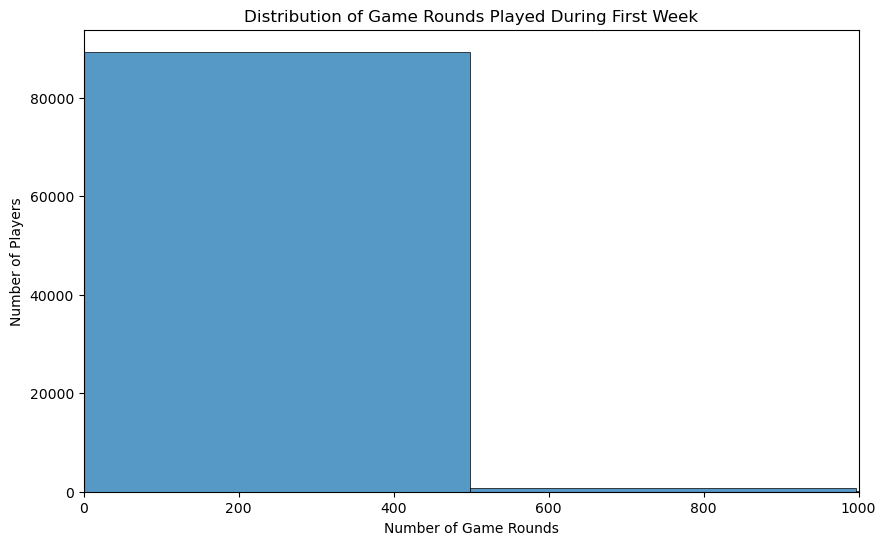

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64


In [71]:
# plot distribution of the number of game rounds players played
plt.figure(figsize=(10,6))
sns.histplot(df['sum_gamerounds'], bins=100)
plt.title('Distribution of Game Rounds Played During First Week')
plt.xlabel('Number of Game Rounds')
plt.ylabel('Number of Players')
plt.xlim(0, 1000) # Limiting x-axis for better visibility
plt.show()

# get descriptive statistics
print(df['sum_gamerounds'].describe())

In [72]:
# Identify the outlier
outlier = df[df['sum_gamerounds'] > 20000]
print(f"Outlier row to be removed:\n{outlier}\n")
#Remove the outlier from dataframe
df = df[df['sum_gamerounds'] < 20000]
#Verify by checking new max value
print("Descriptive statistics after removing outlier:")
print(df['sum_gamerounds'].describe())

Outlier row to be removed:
        userid  version  sum_gamerounds  retention_1  retention_7
57702  6390605  gate_30           49854        False         True

Descriptive statistics after removing outlier:
count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64


In [73]:
#calculate the number of players who retained at 1 day and 7 days
retained_1_day = df['retention_1'].sum()
retained_7_days = df['retention_7'].sum()
#Calculate total number of players
total_players = df['userid'].count()
#Calculate retention rates
retention_rate_1 = retained_1_day / total_players
retention_rate_7 = retained_7_days / total_players
#Metrics output
print(f"Overall 1-day Retention: {retention_rate_1:.2%}")
print(f"Overall 7-day Retention: {retention_rate_7:.2%}")

Overall 1-day Retention: 44.52%
Overall 7-day Retention: 18.61%


In [74]:
# aggregate data by version to get counts and rates for other retention metrics
retention_summary = df.groupby('version').agg(
    total_users=('userid', 'count'),
    retained_1_day=('retention_1', 'sum'),
    retained_7_days=('retention_7', 'sum')
).reset_index()

# calculate retention rates
retention_summary['retention_rate_1'] = retention_summary['retained_1_day'] / retention_summary['total_users']
retention_summary['retention_rate_7'] = retention_summary['retained_7_days'] / retention_summary['total_users']

print("\nRetention Summary by Group:")
print(retention_summary)


Retention Summary by Group:
   version  total_users  retained_1_day  retained_7_days  retention_rate_1  \
0  gate_30        44699           20034             8501          0.448198   
1  gate_40        45489           20119             8279          0.442283   

   retention_rate_7  
0          0.190183  
1          0.182000  


In [75]:
count = retention_summary['retained_1_day'].to_numpy()
nobs = retention_summary['total_users'].to_numpy()
#perform the z - test
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print(f"\n'1-Day Retention A/B Test")
print(f"\nP=value: {p_value:.4f}")

if p_value < 0.05:
    print("Result is statistically significant. The change in gate placement impacted 1-day retention.")
else:
    print("Result is not statistically significant. The change in gate placement did not impact 1-day retention.")


'1-Day Retention A/B Test

P=value: 0.0739
Result is not statistically significant. The change in gate placement did not impact 1-day retention.


In [76]:
count = retention_summary['retained_7_days'].to_numpy()
nobs = retention_summary['total_users'].to_numpy()
#perform the z - test
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print(f"\n'7-Day Retention A/B Test")
print(f"\nP-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result is statistically significant. The change in gate placement impacted 7-day retention.")
else:
    print("Result is not statistically significant. The change in gate placement did not impact 7-day retention.")


'7-Day Retention A/B Test

P-value: 0.0016
Result is statistically significant. The change in gate placement impacted 7-day retention.


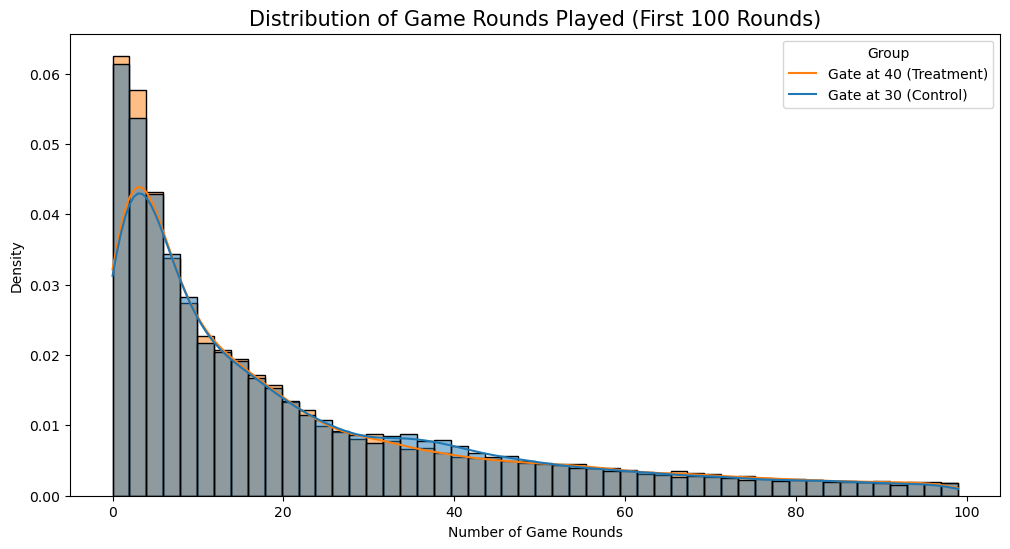

In [77]:
# Create new DataFrame for plotting, zoomed in on the 0-100 round range
df_zoomed = df[df['sum_gamerounds'] < 100]

#Create side by side histograms ( or density plot)
plt.figure(figsize=(12,6))
sns.histplot(data=df_zoomed, x='sum_gamerounds', hue='version', common_norm=False, stat='density', kde=True, bins=50)

plt.title('Distribution of Game Rounds Played (First 100 Rounds)', fontsize=15)
plt.xlabel('Number of Game Rounds')
plt.ylabel('Density')
plt.legend(title = 'Group', labels=['Gate at 40 (Treatment)', 'Gate at 30 (Control)'])
plt.show()

In [78]:
# seperate data into two independent samples 
gate_30_rounds = df[df['version'] == 'gate_30']['sum_gamerounds']
gate_40_rounds = df[df['version'] == 'gate_40']['sum_gamerounds']

# perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(gate_30_rounds, gate_40_rounds, alternative='two-sided')

print(f"\n Player Engagement (Mann-Whitney U Test) ")
print(f"U Statistic: {u_statistic: .0f}")
print(f"P-Value: {p_value: .4f}")

if p_value < 0.05:
    print("Result is statistically significant. The change in gate placement impacted player engagement.")
else:
    print("Result is not statistically significant. The change in gate placement did not impact player engagement.")


 Player Engagement (Mann-Whitney U Test) 
U Statistic:  1024285762
P-Value:  0.0509
Result is not statistically significant. The change in gate placement did not impact player engagement.
